<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning
for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
font = {"family": "sans-serif",
        "weight": "normal",
		"size": 10.5}
mpl.rc('font', **font)

# Outline

In the last tutorial, we covered the very basics of Stan. In this tutorial, we will further develop our skills at implementing Bayesian statistical models in Stan by building a *simple linear regression model*. We will use the WHO life expectancy dataset, described below, to infer the relationship between GPD per capita and life expectancy. You will be introduced to the 3 remaining blocks in Stan: `transformed data`, `transformed parameters`, and `generated quantities` blocks. You will also be introduced to the concept of posterior predictive checks (PPCs) and how to implement them in Stan.

## Dataset
We will use an updated version of the WHO life expectancy dataset. Data contains life expectancy, health, immunization, and economic and demographic information about 179 countries from 2000-2015 years. The dataset has 21 variables and 2,864 rows. The list of variables is as follows:
- `Country`: Name of the country
- `Region`: Region the country belongs to
- `Year`: The year of observation
- `Infant_deaths`: Number of Infant Deaths per 1000 population
- `Under_five_deaths`: Number of under-five deaths per 1000 population
- `Adult_mortality`: Number of adult deaths per 1000 population
- `Alcohol_consumption`: Alcohol consumption per capita (15+), liters
- `Hepatitis_B`: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
- `Measles`: Percentages of measles immunization among 1-year-olds (%)
- `BMI`: Average Body Mass Index of the entire population
- `Polio`: Polio immunization coverage among 1-year-olds (%)
- `Diphtheria`: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
- `Incidents_HIV`: Incidents of HIV per 1000 population aged 15-49
- `GDP_per_capita`: Gross Domestic Product per capita (in USD)
- `Population_mln`: Population in millions
- `Thinness_ten_nineteen_years`: Prevalence of thinness among children and adolescents for Age 10 to 19 (%)
- `Thinness_five_nine_years`: Prevalence of thinness among children for Age 5 to 9 (%)
- `Schooling`: Average years that people aged 25 or older have spent in school
- `Economy_status_Developed`: Developed country indicator
- `Economy_status_Developing`: Developing country indicator
- `Life_expectancy`: Life expectancy in age

Let's start by loading the data and exploring it.

In [2]:
df = pd.read_csv("../../data/who_life_expectancy.csv")

In [3]:
print(df.columns)

Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
       'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
       'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
       'Population_mln', 'Thinness_ten_nineteen_years',
       'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
       'Economy_status_Developing', 'Life_expectancy'],
      dtype='object')


In [4]:
df.head(5)

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


To keep things simple, we will only use the data from 2007 in this tutorial. We will extend the model to include data from other years in a later tutorial.

In [5]:
# Subset the data to 2007
df_2007 = df[df["Year"] == 2007]

## Objective

The objective of this analysis is the model the relationship between GDP per capita of a country and its life expectancy. We want to determine if there is a significant linear relationship between the two variables. We also want to assess whether life expectancy can be modeled adequately by GDP per capita alone.

## Exploratory Data Analysis

In [6]:
# Subset the data to the columns we are interested in
df_subset_2007 = df_2007[['Country', 'Year', 'Life_expectancy', 'GDP_per_capita']]

Plot a histogram of GDP per capita and life expectancy. Plot a scatter plot of GDP per capita vs life expectancy.

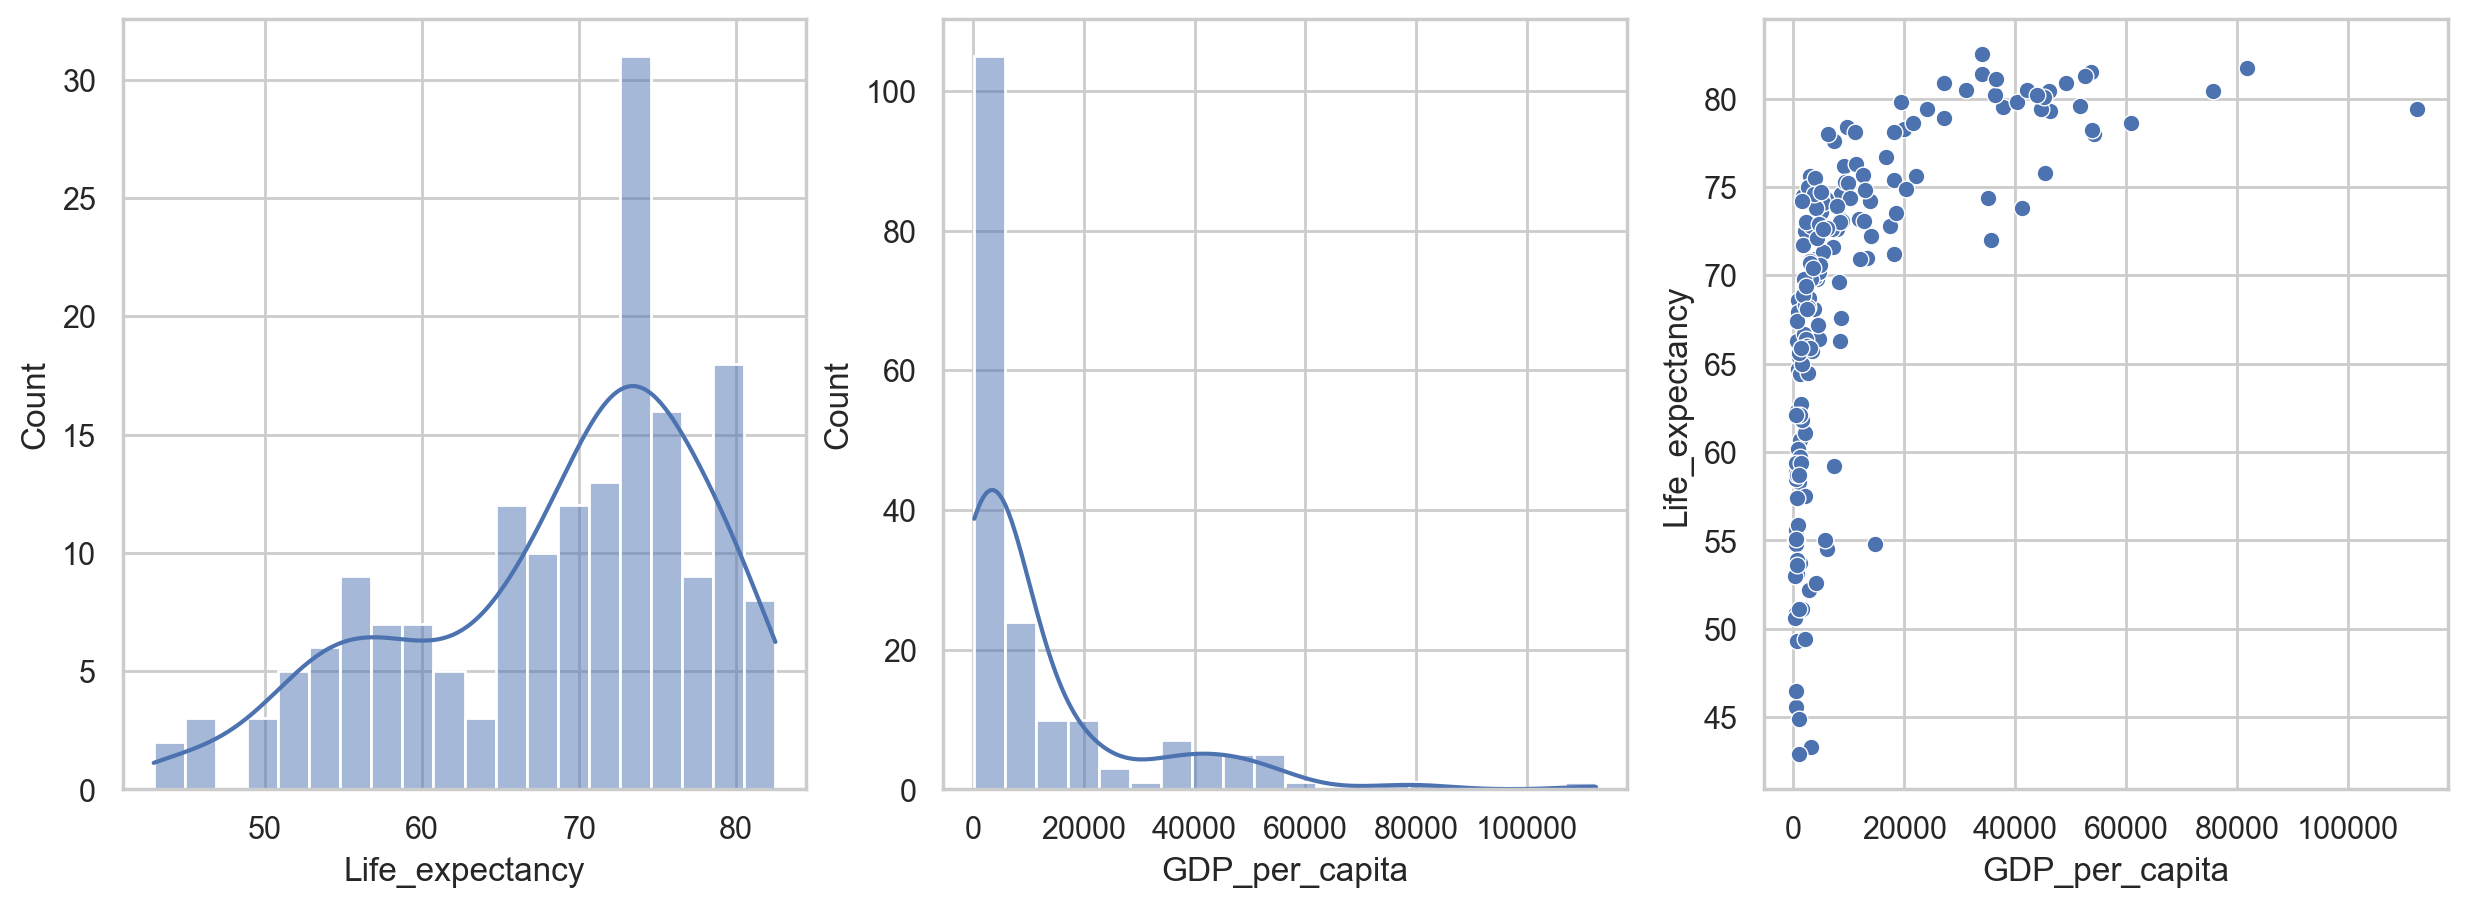

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=200)

sns.histplot(data=df_subset_2007, x='Life_expectancy', bins=20, kde=True, ax=ax[0])
sns.histplot(data=df_subset_2007, x='GDP_per_capita', bins=20, kde=True, ax=ax[1])
sns.scatterplot(data=df_subset_2007, x='GDP_per_capita', y='Life_expectancy', ax=ax[2])
plt.show()

The histogram and the scatter plot suggest that we should apply a log transformation to GDP per capita. While the general recommendation is to apply the transformation outside of the Stan code, we will do so for demonstration purposes. But before we do, let's visually inspect the relationship between the two variables after applying the log transformation.

In [8]:
df_subset_2007['log_GDP_per_capita'] = np.log(df_subset_2007['GDP_per_capita'].values)

/var/folders/fc/szc97hhx4sgg1mzfl9bt0n240000gn/T/ipykernel_56098/1900103787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_2007['log_GDP_per_capita'] = np.log(df_subset_2007['GDP_per_capita'].values)


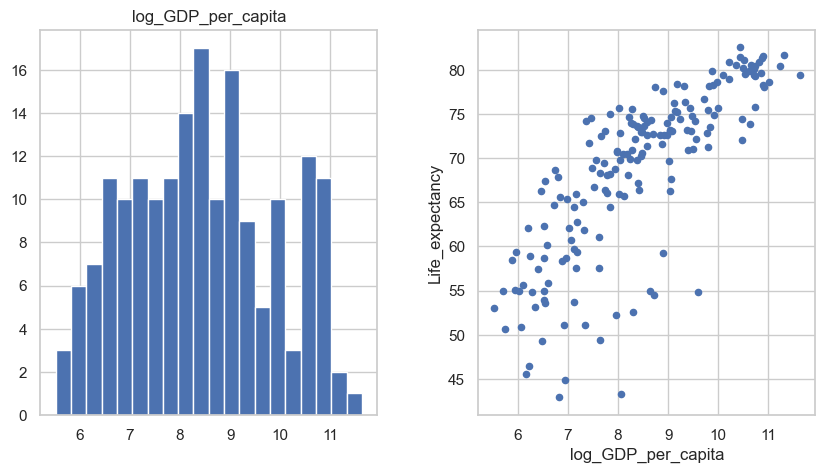

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
df_subset_2007.hist(column='log_GDP_per_capita', bins=20, ax=ax[0])
df_subset_2007.plot(x='log_GDP_per_capita', y='Life_expectancy', kind='scatter', ax=ax[1])
plt.show()

## Stan Model

Let $y_i$ for $i = 1, 2, \ldots, n$ be the life expectancy of the $i$-th country and $x_i$ be the GDP per capita of the $i$-th country. We will model the relationship between life expectancy and GDP per capita as follows:
$$
\begin{align*}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \beta_0 + \beta \log(x_i).
\end{align*}
$$

Now, let us think about the priors on the parameters. Looking at the scatter plot, we can see that the intercept might be close to 0, and the slope might be close to 5. However, we are just eyeballing the data. We will reflect the our uncertainty by using "weakly informative" priors on $\beta_0$ and $\beta$. We will use a normal prior with mean 0 and standard deviation 10 for $\beta_0$ and a normal prior with mean 5 and standard deviation 5 for $\beta$. For $\sigma$, we see that the spread of the data given a value of $x_i$ is around 10. We will use an exponential prior in the inverse of $\sigma$ with rate 5, which gives $\sigma$ a prior mean of 5. In summary, our priors are as follows:
$$
\begin{align*}
\beta_0 &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Normal}(5, 5) \\
1/\sigma &\sim \text{Exponential}(5)
\end{align*}
$$

The model above translates to the following Stan code (`simple_linear_regression.stan`):
```stan
data {
  int<lower=1> N;
  vector[N] x;
  array[N] real y;
}
transformed data {
  // Apply log transformation to x
  vector[N] log_x = log(x);
}
parameters {
  real beta0;
  real beta;
  real<lower=0> inv_sigma;
}
transformed parameters {
  vector[N] mu;
  mu = beta0 + beta * log_x;
}
model {
  // Priors
  beta0 ~ normal(0, 10);
  beta ~ normal(0, 1);
  inv_sigma ~ exponential(5);

  // Likelihood
  y ~ normal(mu, 1/inv_sigma);
}
generated quantities {
  vector[N] log_lik;
  array[N] real yrep;

  for (i in 1:N) {
    log_lik[i] = normal_lpdf(y[i] | mu[i], 1/inv_sigma);
    yrep[i] = normal_rng(mu[i], 1/inv_sigma);
  } 
}
```
Notice that we have added the `transformed data`, `transformed parameters`, and `generated quantities` blocks to the Stan code. We will break down the code block by block.

#### `data` Block:
```stan
data {
  int<lower=1> N;       // Number of data points
  vector[N] x;          // Predictor variable
  array[N] real y;      // Response variable
}
```
- `N`: The number of observations in the dataset. The constraint <lower=1> ensures that there is at least one observation.
- `x`: A vector of predictor variables. A vector can only contain real numbers.
- `y`: An array of real numbers representing the response variable.

#### `transformed data` Block:
The `transformed data` block is used to preprocess the data before the model is fit. In this case, we apply a log transformation to the predictor variable `x`.
```stan
transformed data {
  // Apply log transformation to x
  vector[N] log_x = log(x);
}
```
- `log_x`: This new variable holds the natural logarithm of each element in x. This transformation is performed once and used in subsequent calculations, improving efficiency.

#### `parameters` Block:
```stan
parameters {
  real beta0;           // Intercept
  real beta;            // Slope
  real<lower=0> inv_sigma;  // Inverse of standard deviation
}
```
- `beta0` and `beta`: Parameters representing the intercept and slope of the linear model, respectively.
- `inv_sigma`: The precision (inverse of variance) of the residuals in the linear model. It is constrained to be positive.

#### `transformed parameters` Block:
The purpose of the `transformed parameters` block is to define new variables that are derived from the parameters and data. In this case, we calculate the expected value of the response variable `y` based on the linear model. The variables defined in this block will be saved and can be accessed afted the model is fit.
```stan
transformed parameters {
  vector[N] mu;         // Expected value of y
  mu = beta0 + beta * log_x;
}
```
- `mu`: Represents the expected value (mean) of the response variable y, calculated using the linear model with the transformed predictor log_x.

#### `model` Block:
```stan
model {
  // Priors
  beta0 ~ normal(0, 10);
  beta ~ normal(0, 1);
  inv_sigma ~ exponential(5);

  // Likelihood
  y ~ normal(mu, 1/inv_sigma);
}
```
**Priors**:
- `beta0` and `beta` are assumed to follow normal distributions with specified means and standard deviations. These priors express beliefs about the parameters before observing the data.
- `inv_sigma` follows an exponential distribution, indicating a belief that smaller values (larger variance) are less likely.

**Likelihood**:
- Specifies that y is normally distributed with mean mu and precision inv_sigma. This is the core of the Bayesian model linking data to the parameters.

#### `generated quantities` Block:
This block calculates quantities that are derived from the parameters of the model and/or the data, which are not required for fitting the model but may be useful for model checking, validation, or forecasting.
```stan
generated quantities {
  vector[N] log_lik;    // Log-likelihood of each observation
  array[N] real yrep;   // Replicated data points

  for (i in 1:N) {
	log_lik[i] = normal_lpdf(y[i] | mu[i], 1/inv_sigma);
	yrep[i] = normal_rng(mu[i], 1/inv_sigma);
  } 
}
```
- `log_lik`: An array holding the log likelihood for each observation. This can be used for model diagnostics, such as calculating the WAIC.
- `yrep`: Simulated (replicated) data based on the model, useful for posterior predictive checks.

## Fitting the Model

As before, we first compile the Stan model using the `CmdStanModel` class.

In [10]:
model = CmdStanModel(stan_file="../stan/simple_linear_regression.stan")

15:55:48 - cmdstanpy - INFO - compiling stan file /Users/shozendan/Imperial/stats_ml_population_health/3_intro_to_stan/stan/simple_linear_regression.stan to exe file /Users/shozendan/Imperial/stats_ml_population_health/3_intro_to_stan/stan/simple_linear_regression
15:56:00 - cmdstanpy - INFO - compiled model executable: /Users/shozendan/Imperial/stats_ml_population_health/3_intro_to_stan/stan/simple_linear_regression


Next, we prepare the data for Stan by creating a Python dictionary with the required elements.

In [11]:
stan_data = {
	"N": df_subset_2007.shape[0],
	"x": df_subset_2007['GDP_per_capita'],
	"y": df_subset_2007['Life_expectancy']
}

Finally, we can run the inference algorithm using `CmdStanModels`'s `sample` method.
Note that we specify a few additional arguments in the `sample` method:
- `chains`: The number of chains to run. We will use 4 chains.
- `iter_warmup`: The number of warmup iterations. We use 500 warmup iterations.
- `iter_sampling`: The number of sampling iterations. We use 1000 sampling iterations.
- `seed`: A random seed for reproducibility.

In [12]:
fit = model.sample(data=stan_data, chains=4, iter_warmup=500, iter_sampling=1000, seed=0)

15:56:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:56:01 - cmdstanpy - INFO - CmdStan done processing.


## Posterior Analysis

A general first step after fitting a model is to check if the sampling alogorith did not encounter any issues. Recall that we can perform a quick check of the key diagnostics using the `diagnose` method.

In [13]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



It seems like the sampling went well. Next we want to analyse the posterior distribution to answer the questions we posed earlier. The ArviZ library provides a convenient interface to analyse the posterior samples. We can use the `from_cmdstanpy` method to convert the output of the Stan model to an ArviZ InferenceData object.

In [14]:
idata = az.from_cmdstanpy(fit)

Now we can use the `summary()` method to get a summary of the posterior distribution of the parameters of interest. We can use the `var_names` argument to specify which parameters we want to include in the summary.

In [15]:
az.summary(idata, var_names=["beta0", "beta", "inv_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,27.458,2.474,23.047,32.128,0.065,0.046,1486.0,1604.0,1.0
beta,4.876,0.288,4.332,5.397,0.007,0.005,1507.0,1690.0,1.0
inv_sigma,0.171,0.009,0.154,0.188,0.000,0.000,1694.0,1638.0,1.0


By default the `summary()` method provides the mean, standard deviation, highest posterior density interval (HPDI), and MCMC diagnostics for each parameter. This is useful to gain a quick grasp of the posterior as well as to check for convergence and mixing issues. For good measure, we can also plot the kernel density estimate (KDE) and trace plots of the parameters.

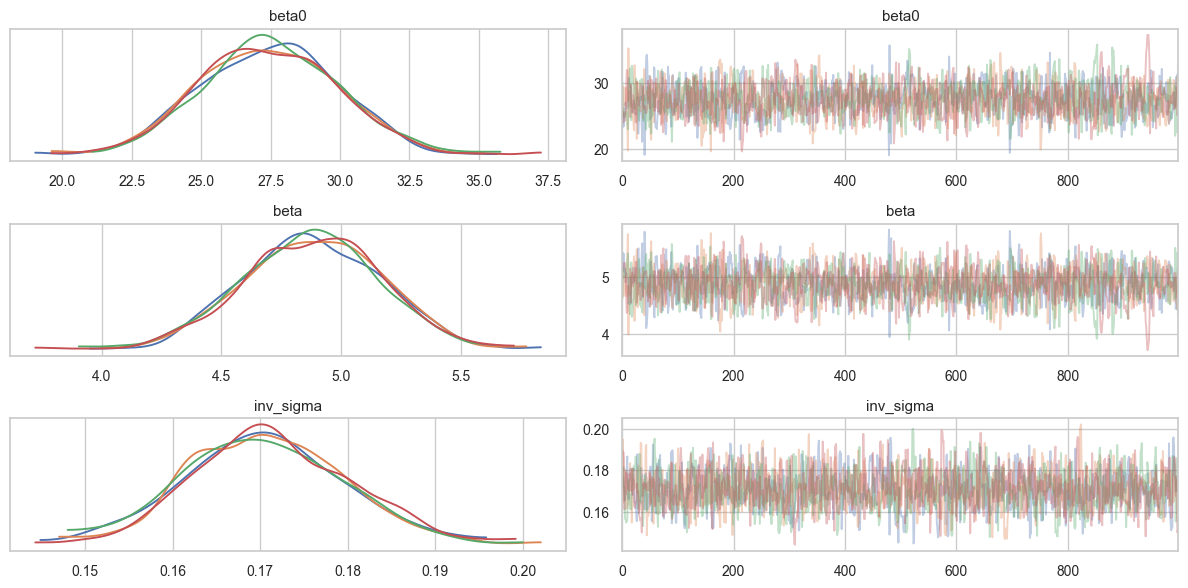

In [16]:
az.plot_trace(idata, var_names=['beta0', 'beta', 'inv_sigma'], compact=False, combined=False)
plt.tight_layout()
plt.show()

The trace plots and the MCMC diagnostics suggest that the chains have converged and mixed well. We can now proceed to interpret the results.


Suppose that instead of the HPDI we want to use the quantiles to summarise the posterior. We can define a dictionary with custom summary functions and pass it to the `summary()` method using the `stat_funcs` argument. To keep the summary concise, also want to exclude the MCMC diagnostics. We can do this by setting the `extend` argument to `False`.

In [17]:
custom_stats = {
    "median": lambda x: np.percentile(x, 50),
	"ci_2.5%": lambda x: np.percentile(x, 2.5),
	"ci_97.5%": lambda x: np.percentile(x, 97.5)
}

az.summary(idata, var_names=["beta0", "beta", "inv_sigma"], stat_funcs=custom_stats, extend=False)

,median,ci_2.5%,ci_97.5%
beta0,27.422,22.772,32.251
beta,4.881,4.314,5.418
inv_sigma,0.170,0.153,0.189


From the summary table, we can conclude that there is a significant positive relationship between GDP per capita and life expectancy based on the fact that the 95% credible interval for the slope parameter $\beta$ does not include zero. Let us also visualise the inferred line along with the data points. Recall that we defined the `mu` variable in the `transformed parameters` block. We can use this variable to plot the inferred line.

In [18]:
# Summarise the posterior of the mu parameter
post_mu = az.summary(idata, var_names=['mu'], stat_funcs=custom_stats, extend=False)

# Append the data to the summary
post_mu['GDP_per_capita'] = df_subset_2007['GDP_per_capita'].values
post_mu['log_GDP_per_capita'] = df_subset_2007['log_GDP_per_capita'].values
post_mu['Life_expectancy'] = df_subset_2007['Life_expectancy'].values

# Sort the data by the log_GDP_per_capita
post_mu = post_mu.sort_values('log_GDP_per_capita')

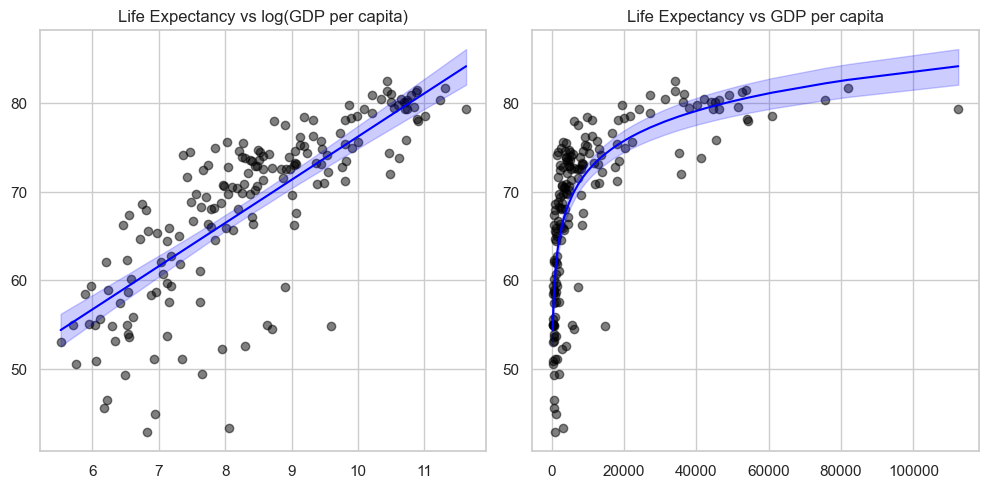

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

# Plot the data
ax[0].scatter(post_mu['log_GDP_per_capita'], post_mu['Life_expectancy'], color='black', alpha=0.5)
ax[0].plot(post_mu['log_GDP_per_capita'], post_mu['median'], color='blue')
ax[0].fill_between(post_mu['log_GDP_per_capita'], post_mu['ci_2.5%'], post_mu['ci_97.5%'], color='blue', alpha=0.2)
ax[0].set_title("Life Expectancy vs log(GDP per capita)")

ax[1].scatter(post_mu['GDP_per_capita'], post_mu['Life_expectancy'], color='black', alpha=0.5)
ax[1].plot(post_mu['GDP_per_capita'], post_mu['median'], color='blue')
ax[1].fill_between(post_mu['GDP_per_capita'], post_mu['ci_2.5%'], post_mu['ci_97.5%'], color='blue', alpha=0.2)
ax[1].set_title("Life Expectancy vs GDP per capita")

plt.tight_layout()
plt.show()

### Posterior Predictive Checks

Posterior predictive checks (PPCs) are a means to validate a model by comparing the predictions derived from the model to the actual observed data. The posterior predictive distribution for new data $y_rep$ given observed data $y$ is defined as:
$$
\begin{align*}
p(y_{\text{rep}} | y) = \int p(y_{\text{rep}} | \theta) p(\theta | y) d\theta
\end{align*}
$$
where
- $y_rep$: Replicated data points
- $y$: Observed data
- $\theta$: Parameters of the model
- $p(y_{\text{rep}} | \theta)$: Likelihood of the replicated data given the parameters
- $p(\theta | y)$: Posterior distribution of the parameters given the observed data
- The integral averages over all possible parameter values, weighted by their posterior probabilities.

Algorithmically speaking, we can obtain samples from the posterior predictive by following these steps:
1. Generate $\theta$ from $p(\theta | y)$.
2. For each sample of $\theta$, generate $y_{\text{rep}}$ from $p(y_{\text{rep}} | \theta)$.

In Stan, we use the `generated quantities` block to generate samples from the posterior predictive:
```stan
generated quantities {
  array[N] real y_rep;   // Replicated data points

  for (i in 1:N) {
	y_rep[i] = normal_rng(mu[i], 1/inv_sigma);
  } 
}
```

#### Why Perform PPCs?
1. **Model Validation**: PPCs are a direct way to test the model's validity - how well the model can produce data that resemble the observed data. If the replicated data consistently differ from the observed data, this might suggest that the model is misspecified or that key variables or structures are missing.
2. **Checking Model Assumptions**: They allow researchers to assess whether the assumptions of the model (e.g., distributional assumptions, independence, homoscedasticity) are reasonable. Discrepancies in these checks can prompt a re-evaluation of model assumptions.
3. **Identifying Model Limitations**: PPCs help highlight areas where the model may be performing poorly, guiding modifications to the model or the decision-making process regarding its use.
4. **Enhanced Understanding and Communication**: Visual comparisons (like overlaying histograms of observed and simulated data) provide an intuitive way to understand how well the model works and communicate this to others.

The `y_rep` variable in the `generated quantities` block contains the replicated data points. Again, we can extract them using the `summary` method from ArviZ.

In [20]:
post_y_rep = az.summary(idata, var_names=['y_rep'], stat_funcs=custom_stats, extend=False)

First, we calculate the proportion of observed data that falls inside the 95% credible interval of the posterior predictive.

In [21]:
post_y_rep['y'] = df_subset_2007['Life_expectancy'].values
post_y_rep['within_95_ci'] = np.where((post_y_rep['ci_2.5%'] < post_y_rep['y']) & (post_y_rep['ci_97.5%'] > post_y_rep['y']), 1, 0)

print('Proportion of points within 95% CI {}'.format(post_y_rep['within_95_ci'].mean()))

Proportion of points within 95% CI 0.9329608938547486


We can also plot the posterior predictive distribution against the observed data to visually assess model fit.

In [22]:
post_y_rep['GDP_per_capita'] = df_subset_2007['GDP_per_capita'].values
post_y_rep['log_GDP_per_capita'] = df_subset_2007['log_GDP_per_capita'].values
post_y_rep = post_y_rep.sort_values('log_GDP_per_capita')

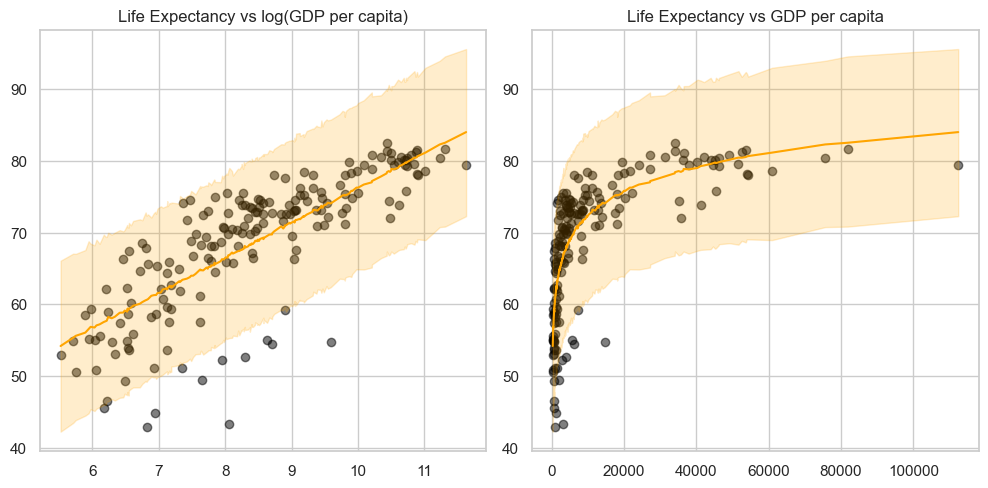

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)

ax[0].scatter(post_y_rep['log_GDP_per_capita'], post_y_rep['y'], color='black', alpha=0.5)
ax[0].plot(post_y_rep['log_GDP_per_capita'], post_y_rep['median'], color='orange')
ax[0].fill_between(post_y_rep['log_GDP_per_capita'], post_y_rep['ci_2.5%'], post_y_rep['ci_97.5%'], color='orange', alpha=0.2)
ax[0].set_title("Life Expectancy vs log(GDP per capita)")

ax[1].scatter(post_y_rep['GDP_per_capita'], post_y_rep['y'], color='black', alpha=0.5)
ax[1].plot(post_y_rep['GDP_per_capita'], post_y_rep['median'], color='orange')
ax[1].fill_between(post_y_rep['GDP_per_capita'], post_y_rep['ci_2.5%'], post_y_rep['ci_97.5%'], color='orange', alpha=0.2)
ax[1].set_title("Life Expectancy vs GDP per capita")

plt.tight_layout()
plt.show()

We find that 93% of the observed data falls within the 95% credible interval of the posterior predictive distribution. However, the model seems to be failing for several contries wil lower GDP per capita. Also, while 93% seems like a good coverage, upon visual inspection, we see that the variance may be overestimated. Ideally we would like to have a tighter credible interval around the data points for predictions to be useful.

The question is, why is the posterior variance of the predictions so high? Well, one possible explanation is that the model is too simple. It is pretty clear from the plot above that the relationship between log(GDP per capita) and life expectancy is still not linear and that the variance of the residuals is not constant. One way to address this is to include higher-order terms in the model to capture the non-linear relationship. We will explore this in the next tutorial.